### Abstract

The code for my LR implementation can be found on GitHub [here](https://github.com/ellisterling/ellisterling.github.io/blob/main/posts/logistic-regression/logistic.py).

In this blog post, we will implement Logistic Regression and run various experiments to test our implementation. Logistic Regression uses the gradient of a feature matrix to approximate the best next option for the weight vector w. We iterate through this step until the weight vector is optimal and the loss function has converged. Our initial tests will include a basic test of performance on synthetic data, a comparison of the Gradient Descent Optimizer with and without momentum, and a test in which we force overfitting of the model by increasing the features so they outnumber the number of data points. After these synthetic data experiments, we will run our model on some real-world data to see how it performs on an actual dataset.

### Experiments

In [1]:
%load_ext autoreload
%autoreload 2
from logistic import GradientDescentOptimizer

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
import numpy as np

First, lets define the function with which we will create our synthetic data. The code for this function was taken from Prof. Phil Chodrow's lecture notes.

In [3]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.5)

#### Vanilla Gradient Descent

Now, we will run our model on this synthetic data with beta=0, which is called Vanilla Gradient Descent. We want to see how it performs without momentum so we can compare later on.

In [4]:
opt = GradientDescentOptimizer()
loss_arr = []
for _ in range(500):
    loss = opt.loss(X, y)
    loss_arr.append(loss)
    opt.step(X, y, alpha = 0.3, beta = 0.0)

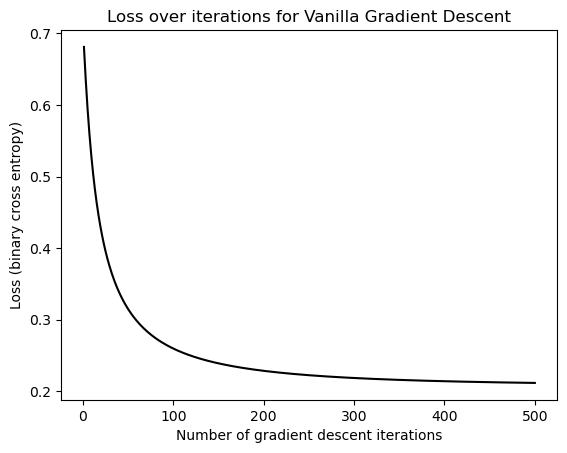

In [5]:
plt.plot(torch.arange(1, len(loss_arr)+1), loss_arr, color = "black")
plt.title("Loss over iterations for Vanilla Gradient Descent")
labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss (binary cross entropy)")

Great, we can see that our loss function has converged. Let's plot our weight vector and see how it separates our data.

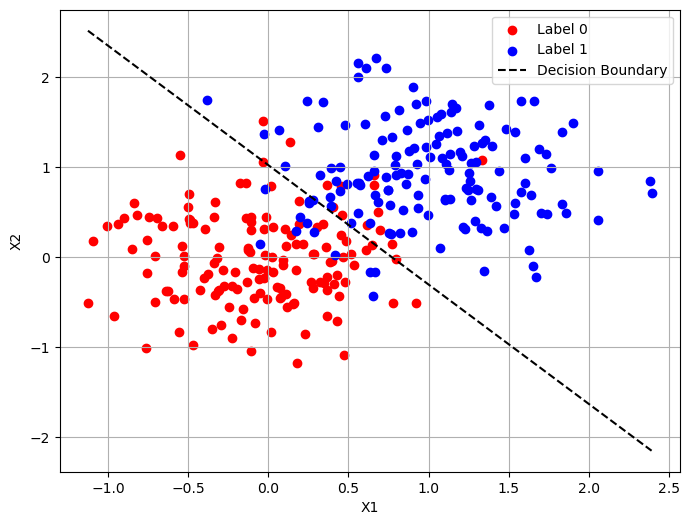

In [6]:
def plot_data_and_w(X, y, w):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', label='Label 0')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Label 1')

    # Decision boundary: w0*x + w1*y + w2 = 0
    x_vals = torch.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    if w[1] != 0:
        y_vals = -(w[0] * x_vals + w[2]) / w[1]
        plt.plot(x_vals, y_vals, 'k--', label='Decision Boundary')

    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_data_and_w(X, y, opt.w)

Looking good! Our vector looks visually correct. Now let's compare with a model where we add momentum.

#### Gradient Descent with Momentum

Now, we want to prove that adding momentum can speed up convergence in some cases. Let's create a new model with beta = 0.9 and run it for the same number of iterations that we ran our Vanilla Gradient Descent Model for.

In [7]:
opt2 = GradientDescentOptimizer()
loss_arr2 = []
for _ in range(500):
    loss = opt2.loss(X, y)
    loss_arr2.append(loss)
    opt2.step(X, y, alpha = 0.3, beta = 0.9)

Now we can plot the loss curves!

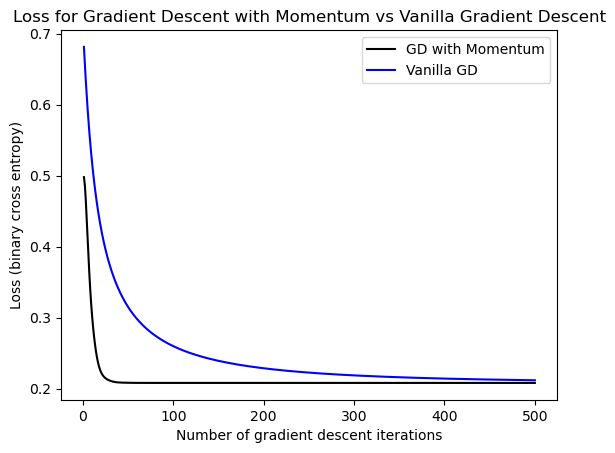

In [8]:
ax = plt.axes()
ax.plot(torch.arange(1, len(loss_arr2)+1), loss_arr2, color = "black", label = "GD with Momentum")
ax.plot(torch.arange(1, len(loss_arr)+1), loss_arr, color = "blue", label = "Vanilla GD")
ax.set_title("Loss for Gradient Descent with Momentum vs Vanilla Gradient Descent")
ax.legend()
labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss (binary cross entropy)")

We can see that the model with momentum converges much faster than the model without for these choices in alpha and beta. 

#### Forcing Overfitting

Now that we've confirmed that our model performs as we would expect, let's test it on some data with too many features. We want to force overfitting in this case.

In [9]:
X_train, y_train = classification_data(n_points=50, noise = 0.5, p_dims=5000)
X_test, y_test = classification_data(n_points=50, noise = 0.5, p_dims=5000)

In [10]:
opt = GradientDescentOptimizer()
loss_arr = []
for _ in range(500):
    opt.step(X_train, y_train, alpha = 0.3, beta = 0)

We've ran our model, so let's take a look at the difference between training data accuracy and testing data accuracy.

In [11]:
predicted = opt.predict(X_train)
(predicted == y_train).sum()/len(predicted)

tensor(1.)

We have 100% accuracy on the training data.

In [12]:
predicted_test = opt.predict(X_test)
(predicted_test == y_test).sum()/len(predicted_test)

tensor(0.7600)

But only 76% accuracy on the testing data! Because of the amount of features that we put in our dataset, the model tried to hard to be accuracte for all of them, and when we gave it another dataset the accuracy dropped dramatically. Moral of the story: don't have more features than data points!

#### Empirical Data

Now for the fun part! We are going to load in a real-world binary classification dataset and test our model performance on it.

The data we will be using is a dataset that contains information related to whether or not people have anemia based on the color of the inside of their eyelid as well as their hemoglobin levels. I obtained this data from the [Kaggle](https://www.kaggle.com/datasets/shahriar26s/anemia-detection-dataset/data). It was collected by Chittagong and Cox’s Bazar Medical College Hospital in Bangladesh. The %red, %blue, and %green fields represent the average pixel percentages from images of patients conjunctiva (the inside of their eyelid).

First, let's process the data and split it into training, testing, and validation datasets.

In [13]:
df = pd.read_csv("./data/anemia_dataset.csv")
df.head()

,Number,Name,%Red Pixel,%Green pixel,%Blue pixel,Hb,Anaemic,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,1,Jafor Alam,43.2555,30.8421,25.9025,6.3,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,khadiza,45.6033,28.1900,26.2067,13.5,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Lalu,45.0107,28.9677,26.0215,11.7,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Mira nath,44.5398,28.9899,26.4703,13.5,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,monoara,43.2870,30.6972,26.0158,12.4,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We'll use the features identified by Patricio et al. as the most pertinent features: Age, BMI, Glucose, and Resistin.

In [14]:
df = df.drop(["Number", "Name", "Unnamed: 7", "Unnamed: 8", "Unnamed: 9", "Unnamed: 10", "Unnamed: 11", "Unnamed: 12", "Unnamed: 13"], axis=1)
df

,%Red Pixel,%Green pixel,%Blue pixel,Hb,Anaemic
0,43.2555,30.8421,25.9025,6.3,Yes
1,45.6033,28.1900,26.2067,13.5,No
2,45.0107,28.9677,26.0215,11.7,No
3,44.5398,28.9899,26.4703,13.5,No
4,43.2870,30.6972,26.0158,12.4,No
...,...,...,...,...,...
99,49.9999,29.2860,20.7141,14.5,Yes
100,42.2324,30.6757,27.0919,6.3,Yes
101,45.6064,31.9084,22.4852,12.7,No
102,45.2095,29.2769,25.5136,13.4,No


In [15]:
X = df.drop("Anaemic", axis=1)
y = df["Anaemic"]
y = y.replace({"Yes": 1, "No": 0})

/var/folders/sy/9tmrg3gx65vf4qjw8jl8ytsc0000gn/T/ipykernel_98315/975647156.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({"Yes": 1, "No": 0})


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state=1) # 25% of 80 is 20, so this should create a 60/20/20 split

In [17]:
X_train = torch.from_numpy(X_train.to_numpy(dtype = np.float32))
X_test = torch.from_numpy(X_test.to_numpy(dtype = np.float32))
X_val = torch.from_numpy(X_val.to_numpy(dtype = np.float32))
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)


First, we'll run our model with Vanilla Gradient Descent.

In [18]:
opt = GradientDescentOptimizer()
loss_arr = []
loss_arr_val = []
for _ in range(100):
    loss = opt.loss(X_train, y_train)
    loss_val = opt.loss(X_val, y_val)
    loss_arr.append(loss)
    loss_arr_val.append(loss_val)
    opt.step(X_train, y_train, alpha = 0.001, beta = 0)

Text(0.5, 1.0, 'Loss over Iterations for Training and Validation Data')

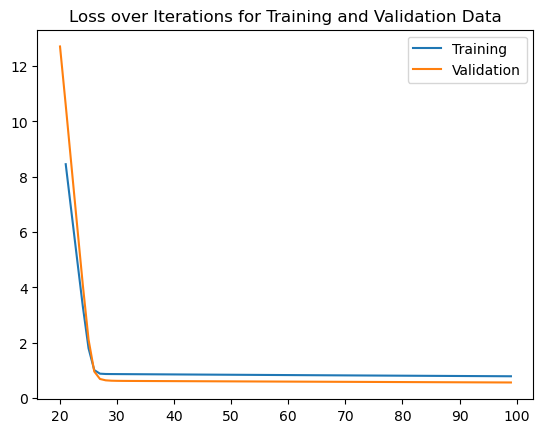

In [19]:
ax = plt.axes()
ax.plot(loss_arr, label="Training")
ax.plot(loss_arr_val, label="Validation")
ax.legend()
ax.set_title("Loss over Iterations for Training and Validation Data")

We can see that it converged, but interestingly the validation loss converged to a slightly smaller value. Now, let's try to run it with momentum.

In [20]:
opt = GradientDescentOptimizer()
loss_arr = []
loss_arr_val = []
for _ in range(100):
    loss = opt.loss(X_train, y_train)
    loss_val = opt.loss(X_val, y_val)
    loss_arr.append(loss)
    loss_arr_val.append(loss_val)
    opt.step(X_train, y_train, alpha = 0.002, beta = 0.9)

Text(0.5, 1.0, 'Loss over Iterations for Training and Validation Data with Momentum')

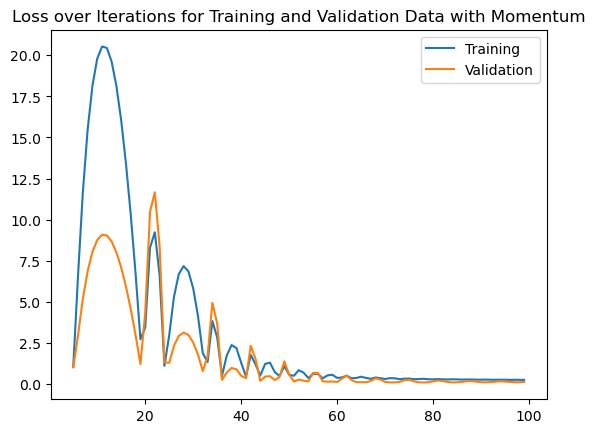

In [21]:
ax = plt.axes()
ax.plot(loss_arr, label="Training")
ax.plot(loss_arr_val, label="Validation")
ax.legend()
ax.set_title("Loss over Iterations for Training and Validation Data with Momentum")

It also converged! Now let's check our model's loss and accuracy on the testing data.

In [22]:
opt.loss(X_test, y_test)

tensor(0.1397)

In [23]:
predicted = opt.predict(X_test)
(predicted == y_test).sum()/len(predicted)

tensor(1.)

We got it to converge to a very small loss, and had 100% accuracy on the testing data. This is interesting because the loss curve for the optimizer with momentum is so unexpected--it has a lot of variability and is not always decreasing. However, we were able to reach really good accuracy with this model, and our loss curves did reach convergence.

### Discussion

In this blog post, we implemented Logistic Regression and performed various experiments with both synthetic and real-world data. We were able to achieve 100% accuracy on both types of data, and we pushed the model to its limits by forcing overfitting. We were able to see the difference between loss curves on synthetic and real data, and we were able to see where Logistic Regression with Gradient Descent fails as a model. In general, it seems like it performs better on datasets with not a lot of features. We were able to observe how our model dramatically decreased in accuracy when we gave it more features than data points. One interesting result from our empirical data experiment is that the Vanilla Gradient Descent model converged faster than the model with momentum, but we were able to achieve faster convergence with momentum on the synthetic data. This helps to illustrate how different alpha and beta parameters are going to work better for different datasets.